In [1]:
import cv2
cv2.__version__

'4.5.4'

In [2]:
# import sample data
#from skimage.data import cells3d
from pathlib import Path
#import ndimage

import napari
from napari.settings import get_settings
import math
import pandas as pd
import os


import statistics as st
import xlsxwriter

import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pyvista as pv

import scipy
from scipy import ndimage as ndi

from scipy.ndimage import label as nd_label
from skimage.segmentation import relabel_sequential
from skimage.measure import label
from skimage.morphology import dilation, square
from skimage.segmentation import find_boundaries
from itertools import combinations

from skimage import io, filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import EllipseModel
from vispy.color import Colormap
from tabulate import tabulate

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.colors import to_rgb, to_hex

from csbdeep.utils import normalize
from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

from IPython.display import display_html, clear_output
from collections import defaultdict
from skimage.segmentation import relabel_sequential

from aicsimageio import AICSImage

from napari.settings import get_settings
settings = get_settings()
settings.application.ipy_interactive = True

2025-06-13 13:55:59.380018: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 13:55:59.385445: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 13:55:59.451607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-13 13:56:00.547593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Functions

In [3]:
def gamma_trans(im_in,gamma):
    val_c = 255.0 / (np.max(im_in)**gamma)
    im_out = val_c*(im_in**gamma)
    return im_out.copy()

def contr_limit(im_in,c_min,c_max):
    alpha = 255.0/(c_max - c_min)
    beta = - c_min * (alpha)
    im_out=(np.clip(alpha*im_in+beta, 0.0, 255.0)).astype(int)
    #print(np.max(im_out))
    return im_out.copy()
    
def histo_equal(im_in):
    h=im_in.shape[1]
    w=im_in.shape[2]
    r=im_in.shape[0]

    tot_pixs=h*w*r

    levels=256

    im_hist = np.zeros((levels))

    for i in range(0,levels):
        im_hist[i] = np.count_nonzero(im_in == i)

    pdf = np.zeros((levels))
    for i in range(0,levels):
        pdf[i] = im_hist[i]/tot_pixs

    cdf = np.zeros((levels))
    cdf[0] = pdf[0]
    for i in range(1, levels):
        cdf[i] = pdf[i] + cdf[i-1]

    im_out=im_in.copy()
        
    for u in range(0,r):
        for j in range(0,h):
            for k in range(0,w):
                im_out[u,j,k] = int(round((levels-1) * cdf[im_in[u,j,k]]))
    return im_out.copy()

def hist_plot(im_in,stain_complete_df,thresh=0):

    fig, axs = plt.subplots(1,im_in.shape[2],figsize=(15,2))

    for z in range(0,im_in.shape[2]):
        hist,bins = np.histogram(im_in[:,:,z].flatten(),256,[0,256])
        
        cdf = hist.cumsum()
        cdf_normalized = cdf* hist.max()/ cdf.max()
    
        color=stain_complete_df.loc[stain_complete_df.index[z],'Color']
    
        axs[z].plot(cdf_normalized, color = 'b')
        if color=='white':
            axs[z].hist(im_in[:,:,z].flatten(),256,[0,256], color = 'gray')
        else:
            axs[z].hist(im_in[:,:,z].flatten(),256,[0,256], color = color)
        axs[z].set_xlim([0,256])
        axs[z].legend(('cdf','histogram'), loc = 'upper left')
        if thresh>0:
            axs[c].plot([thresh,thresh],[0,cdf_normalized.max()],color='g')
        axs[z].set_title(stain_complete_df.index[z])
        axs[z].set_yscale('log')

# Truncate long values for display
def truncate_cell(val, width=15):
    val_str = str(val)
    return val_str if len(val_str) <= width else val_str[:width-3] + "..."

def merge_touching_labels(label_matrix):
    if label_matrix.max() == 0:
        return label_matrix.copy()  # Nothing to merge

    padded = np.pad(label_matrix, 1, mode='constant', constant_values=0)
    touching = defaultdict(set)

    # Build adjacency from 8-connected neighbors
    for i in range(1, padded.shape[0] - 1):
        for j in range(1, padded.shape[1] - 1):
            center = padded[i, j]
            if center == 0:
                continue
            # Only consider neighbors, not the center pixel itself
            neighborhood = padded[i-1:i+2, j-1:j+2].ravel()
            for neighbor in neighborhood:
                if neighbor != center and neighbor != 0:
                    touching[center].add(neighbor)

    # Union-Find setup
    all_labels = set(np.unique(label_matrix)) - {0}
    parent = {label: label for label in all_labels}

    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u

    def union(u, v):
        pu, pv = find(u), find(v)
        if pu != pv:
            parent[pu] = pv

    # Union all touching labels
    for u, neighbors in touching.items():
        for v in neighbors:
            if u in parent and v in parent:
                union(u, v)

    # Map each label to its root
    label_map = {label: find(label) for label in all_labels}

    # Create merged label matrix
    merged = np.zeros_like(label_matrix, dtype=np.int32)
    for label, root in label_map.items():
        merged[label_matrix == label] = root

    # Relabel to sequential labels starting from 1
    merged, _, _ = relabel_sequential(merged)

    return merged

## File upload

In [4]:
tiff_file='PRO_EB-008_2D_M2_5.tif'
meta=AICSImage(tiff_file)

img = meta.get_image_data("XYZ", T=0) 
print(img.shape)

(2883, 2880, 3)


In [5]:
r_X=meta.physical_pixel_sizes.X
r_Y=meta.physical_pixel_sizes.Y
print([r_X,r_Y])

[0.9808829056520209, 0.9808829056520209]


### Information about the staining

In [6]:
stain_dict={
    'MACRO':['F4_80','Red'],
    'M2':['CD206','Green'],
    'NUCLEI':['DAPI','Blue']
}

In [7]:
stain_dict = {k.upper(): [item.upper() if isinstance(item, str) else item for item in v] for k, v in stain_dict.items()}

stain_df = pd.DataFrame.from_dict(stain_dict, orient='index', columns=['Marker', 'Color'])
stain_df.index.name='Condition'

In [8]:
viewer_0 = napari.Viewer()
for c, c_name in enumerate(stain_df['Marker']):
    im_in=meta.get_image_data("XY", Z=c, C=0, S=0, T=0)
    im_in=(im_in/256.0).astype('uint8')
    
    viewer_0.add_image(im_in, name=stain_df.index[c] + ' (' + c_name + ')', 
                        colormap=stain_df['Color'][c], blending='additive')

### Acquisition processing setup

In [9]:
name_setup='PRO_EB-009'
use_setup=True
# stain_new_df=stain_complete_df.copy()

stain_df=stain_df.reset_index(drop=False)
stain_complete_df = stain_df.copy()
stain_complete_df.set_index(['Condition', 'Marker','Color'], inplace=True)
stain_complete_df[['Cont_min','Cont_max','Gamma']]=[0,255,1]

if use_setup and os.path.exists(name_setup + '_setup.csv'):
    stain_setup_df = pd.read_csv(name_setup + '_setup.csv')
    stain_setup_df.set_index(['Condition', 'Marker','Color'], inplace=True)
    #print(tabulate(stain_setup_df, headers='keys', tablefmt='grid', showindex=True))
    for c, c_name in enumerate (list(stain_complete_df.index)):
        if stain_complete_df.index[c] in list(stain_setup_df.index.values):
            stain_complete_df.loc[stain_complete_df.index[c]]=stain_setup_df.loc[stain_complete_df.index[c]]
            # stain_new_df=stain_new_df.drop(stain_complete_df.index[c])
        else:
            use_setup=False

if not(use_setup) or not(os.path.exists(name_setup + '_setup.csv')):

    settings.application.ipy_interactive = False
    viewer_1 = napari.Viewer()
    
    for c, c_name in enumerate (list(stain_complete_df.index)):
        im_in=meta.get_image_data("XY", Z=c, C=0, S=0, T=0)
        im_in=(im_in/256.0).astype('uint8')
            
        viewer_1.add_image(im_in, name=stain_complete_df.index[c][0] + ' (' + stain_complete_df.index[c][1] + ')', 
                            colormap=stain_complete_df.index[c][2],blending='additive')
        
    napari.run()
    
    image_layers = [layer for layer in viewer_1.layers if isinstance(layer, napari.layers.Image)]
    contrast_limits = {layer.name: layer.contrast_limits for layer in image_layers}
    gamma_val = {layer.name: layer.gamma for layer in image_layers}
    
    stain_complete_df.sort_index(inplace=True)
    for c, c_name in enumerate (list(stain_complete_df.index)):
        stain_complete_df.loc[stain_complete_df.index[c], 'Cont_min'] =int(contrast_limits[stain_complete_df.index[c][0] + ' (' + stain_complete_df.index[c][1] + ')'][0])
        stain_complete_df.loc[stain_complete_df.index[c], 'Cont_max'] =int(contrast_limits[stain_complete_df.index[c][0] + ' (' + stain_complete_df.index[c][1] + ')'][1])
        stain_complete_df.loc[stain_complete_df.index[c], 'Gamma'] =gamma_val[stain_complete_df.index[c][0] + ' (' + stain_complete_df.index[c][1] + ')']

    if os.path.exists(name_setup + '_setup.csv'):
        stain_setup_df = pd.read_csv(name_setup + '_setup.csv')
        stain_setup_df.set_index(['Condition', 'Marker','Color'], inplace=True)
        for c, c_name in enumerate (list(stain_complete_df.index)):
            stain_setup_df.loc[stain_complete_df.index[c]]=stain_complete_df.loc[stain_complete_df.index[c]]
    else:
        stain_setup_df = stain_complete_df.copy()

    stain_csv_setup_df = stain_setup_df.reset_index().sort_values(by='Condition')
    stain_csv_setup_df=stain_csv_setup_df[['Condition','Marker','Color','Cont_min','Cont_max','Gamma']]
    stain_csv_setup_df.to_csv(name_setup + '_setup.csv', index=False)

stain_df=stain_df.set_index('Condition')
stain_complete_df=stain_complete_df.reset_index()
stain_complete_df=stain_complete_df.set_index('Condition')
stain_complete_df=stain_complete_df.loc[stain_df.index]

stain_complete_df=stain_complete_df[['Marker','Color','Cont_min','Cont_max','Gamma']]
    
#print(tabulate(stain_complete_df, headers='keys', tablefmt='grid', showindex=True))

In [10]:
stain_complete_df

,Marker,Color,Cont_min,Cont_max,Gamma
Condition,,,,,
MACRO,F4_80,RED,0,117,1
M2,CD206,GREEN,25,194,1
NUCLEI,DAPI,BLUE,0,255,1


## MULTIPLE TRANSFORM

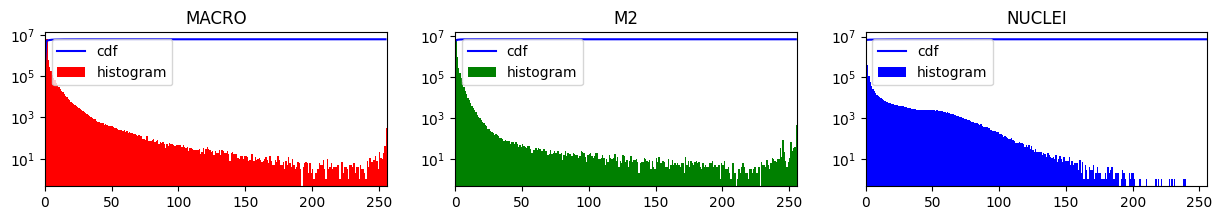

In [11]:
im_in=meta.get_image_data("XYZ", C=0, S=0, T=0)
im_in=im_in.copy()
im_in=(im_in/256.0).astype('uint8')
im_original=im_in.copy()
im_out=im_original.copy()
im_trans=im_out.copy()

hist_plot(im_out,stain_complete_df)

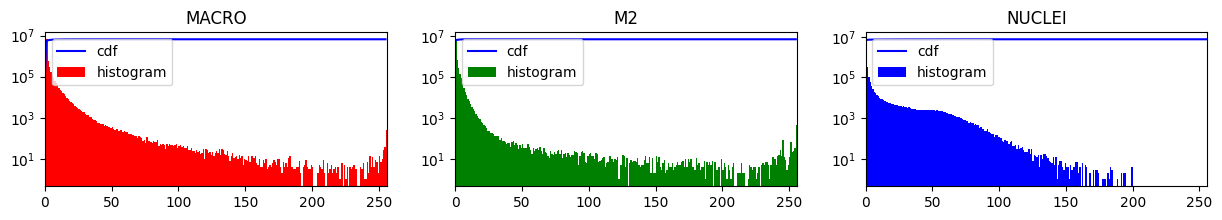

In [12]:
# Noise removal
im_in=im_out.copy()

for z in range(0,im_in.shape[2]):
    im_out[:,:,z]=filters.median(im_in[:,:,z])

im_denoised=im_out.copy()
hist_plot(im_out,stain_complete_df)

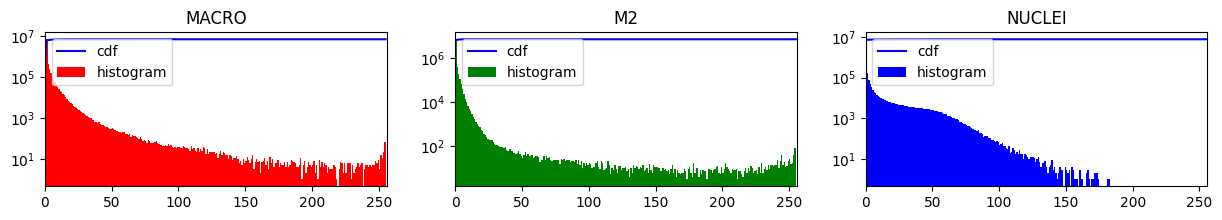

In [13]:
# Gaussian filter
im_in=im_out.copy()

for z in range(0,im_in.shape[2]):
    im_out[:,:,z]=filters.gaussian(im_in[:,:,z],1.0,preserve_range=True)

im_filtered=im_out.copy()
hist_plot(im_out,stain_complete_df)

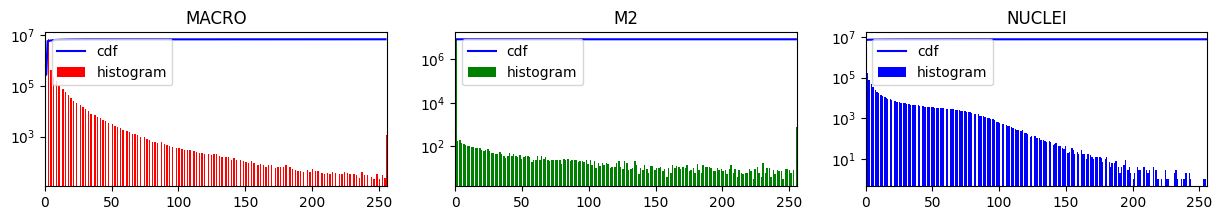

In [14]:
# Contrast and gamma adjustment
im_in=im_out.copy()

for c, c_name in enumerate (list(stain_complete_df.index)):
    im_out[:,:,c]=contr_limit(im_out[:,:,c],stain_complete_df.loc[stain_complete_df.index[c],'Cont_min'],stain_complete_df.loc[stain_complete_df.index[c],'Cont_max'])
    im_out[:,:,c]=gamma_trans(im_out[:,:,c],stain_complete_df.loc[stain_complete_df.index[c],'Gamma'])

im_trans=im_out.copy()
hist_plot(im_out,stain_complete_df)

In [15]:
# Thresholding
im_in=im_out.copy()

for z in range(0,im_in.shape[2]):        
    
    #Threshold filter
    th_filter = sitk.OtsuThresholdImageFilter()
    th_filter.SetInsideValue(0)
    th_filter.SetOutsideValue(200)
    
    seg = th_filter.Execute(sitk.GetImageFromArray(im_in[:,:,z]))
    
    im_out[:,:,z]=sitk.GetArrayFromImage(seg)

im_threshold=im_out.copy()

In [16]:
# Segmentation
im_in=im_out.copy()
im_out=np.zeros_like(im_in, dtype=np.int32)

trig_stardist=False

for z in range(0,im_in.shape[2]):
    if trig_stardist:
        model = StarDist2D.from_pretrained('2D_versatile_fluo')
        img_te = normalize(im_trans[:,:,z],1.0,99.8)
        im_out[:,:,z], _ = model.predict_instances(img_te)
        im_mask=im_in[:,:,z]/np.max(im_in[:,:,z])
        im_mask=ndi.binary_erosion(im_mask,structure=np.ones((2,2))).astype(im_mask.dtype)
        im_positive=im_out[:,:,z]*(im_mask)
        list_positive=list(np.unique(im_positive))
        list_positive=list_positive[1:]
    else:
        distance = ndi.distance_transform_edt(im_in[:,:,z])
        coords = peak_local_max(distance, footprint=np.ones((3,3)), labels=im_in[:,:,z].astype(np.int32))
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        transl = watershed(-distance, markers, mask=im_in[:,:,z])
        im_out[:,:,z] = transl.copy()  # Ensure integer labels
        im_out[:,:,z] = merge_touching_labels(im_out[:,:,z])


cm_rand=np.random.rand(int(np.max(im_out)),3)
cm_rand[0,:]=[0.0,0.0,0.0]
colormaps_rand=Colormap(cm_rand)

#im_out=labels.copy()
im_segmented=im_out.copy()

In [17]:
viewer_0 = napari.Viewer()

for z in range(0,im_in.shape[2]):
    viewer_0.add_image(im_original[:,:,z], name='ORIGINAL '+stain_complete_df.index[z] + ' (' + stain_complete_df.loc[stain_complete_df.index[z],'Marker'] + ')', 
                    colormap=stain_complete_df['Color'].iloc[z], blending='additive')
    viewer_0.add_image(im_denoised[:,:,z], name='DENOISED '+stain_complete_df.index[z] + ' (' + stain_complete_df.loc[stain_complete_df.index[z],'Marker'] + ')', 
                    colormap=stain_complete_df['Color'].iloc[z], blending='additive')
    viewer_0.add_image(im_filtered[:,:,z], name='FILTERED '+stain_complete_df.index[z] + ' (' + stain_complete_df.loc[stain_complete_df.index[z],'Marker'] + ')', 
                    colormap=stain_complete_df['Color'].iloc[z], blending='additive')
    viewer_0.add_image(im_trans[:,:,z], name='CORRECTED '+stain_complete_df.index[z] + ' (' + stain_complete_df.loc[stain_complete_df.index[z],'Marker'] + ')', 
                    colormap=stain_complete_df['Color'].iloc[z], blending='additive')
    viewer_0.add_image(im_threshold[:,:,z], name='THRESHOLDED '+stain_complete_df.index[z] + ' (' + stain_complete_df.loc[stain_complete_df.index[z],'Marker'] + ')', 
                    colormap=stain_complete_df['Color'].iloc[z], blending='additive')
    viewer_0.add_image(im_segmented[:,:,z], name='SEGMENTED '+stain_complete_df.index[z] + ' (' + stain_complete_df.loc[stain_complete_df.index[z],'Marker'] + ')', 
                    colormap=colormaps_rand, blending='additive')

viewer_0.scale_bar.visible=True
viewer_0.scale_bar.unit='um'

## QUANTIFICATION

In [18]:
im_mask = im_segmented > 0
labels_dict = {}

# Single channel stats
for i in range(im_in.shape[2]):
    position_list = []
    size_list = []
    marker = stain_df['Marker'][i]
    for n in range(1, int(np.max(im_segmented[:, :, i])) + 1):
        y, x = np.where(im_segmented[:, :, i] == n)
        mx = np.mean(x * r_X)
        my = np.mean(y * r_Y)
        position_list.append((mx, my))
        size_list.append(np.shape(x)[0] * r_X * r_Y)
    labels_dict[stain_complete_df['Marker'].iloc[i]] = [
        stain_complete_df.index[i],
        stain_complete_df['Color'][i],
        int(np.max(im_segmented[:, :, i])),
        (),
        tuple(position_list),
        tuple(size_list)
    ]

# All combinations of channels (2 or more)
layers_n = list(range(im_mask.shape[2]))
all_combinations = []
for k in range(2, len(layers_n) + 1):
    all_combinations.extend(combinations(layers_n, k))

for comb in all_combinations:
    # Find mask where all channels in comb are positive
    shared_mask = np.ones(im_mask.shape[:2], dtype=bool)
    for idx in comb:
        shared_mask &= im_mask[:, :, idx]
    # If no overlap, skip
    if not np.any(shared_mask):
        continue
    # Stack the labels for all channels in the combination
    shared_labels = np.stack([im_segmented[:, :, idx][shared_mask] for idx in comb], axis=1)
    # Remove background (where any label is zero)
    shared_labels = shared_labels[~np.any(shared_labels == 0, axis=1)]
    if shared_labels.size == 0:
        continue
    unique_shared_labels = np.unique(shared_labels, axis=0)

    position_list = []
    size_list = []
    # For each unique label combination, get mean position and size in the first channel of the combination
    for n in unique_shared_labels:
        y, x = np.where(im_segmented[:, :, comb[0]] == n[0])
        mx = np.mean(x * r_X)
        my = np.mean(y * r_Y)
        position_list.append((mx, my))
        size_list.append(np.shape(x)[0] * r_X * r_Y)

    # Get marker and condition names for this combination
    name_labels = [stain_complete_df['Marker'].iloc[idx] for idx in comb]
    name_colors = [stain_complete_df['Color'].iloc[idx] for idx in comb]
    name_conditions = [stain_complete_df.index[idx] for idx in comb]
    values_labels = [tuple(row) for row in unique_shared_labels]

    labels_dict[tuple(name_labels)] = [
        name_conditions,
        name_colors,
        unique_shared_labels.shape[0],
        tuple(values_labels),
        tuple(position_list),
        tuple(size_list)
    ]

In [19]:
labels_df = pd.DataFrame.from_dict(labels_dict, orient='index', columns=['Condition','Color','Number','Shared labels','Mean positions [um]','Cell size [um2]'])
labels_df.index.name='Combination'

# Make a copy with truncated cell values
truncated_df = labels_df.copy()
truncated_df["Shared labels"] = truncated_df["Shared labels"].apply(lambda x: truncate_cell(x))
truncated_df["Mean positions [um]"] = truncated_df["Mean positions [um]"].apply(lambda x: truncate_cell(x))
truncated_df["Cell size [um2]"] = truncated_df["Cell size [um2]"].apply(lambda x: truncate_cell(x))
    
#print(tabulate(truncated_df, headers='keys', tablefmt='grid', showindex=False))

In [20]:
labels_df

,Condition,Color,Number,Shared labels,Mean positions [um],Cell size [um2]
Combination,,,,,,
F4_80,MACRO,RED,967,(),"((2436.38598615185, 2.2160687868434548), (1973...","(51.955088828418965, 10.583444020603864, 152.0..."
CD206,M2,GREEN,26,(),"((2185.68736605146, 334.2008185685814), (280.5...","(60.614270299822124, 0.9621312746003512, 76.00..."
DAPI,NUCLEI,BLUE,1899,(),"((2705.4425216014333, 2.1292336244641428), (25...","(39.447382258614404, 53.87935137761967, 68.311..."
"(F4_80, CD206)","[MACRO, M2]","[RED, GREEN]",24,"((160, 1), (266, 3), (296, 4), (381, 5), (388,...","((2186.1556823259634, 332.57093043212205), (14...","(36.560988434813346, 149.13034756305444, 161.6..."
"(F4_80, DAPI)","[MACRO, NUCLEI]","[RED, BLUE]",514,"((1, 3), (2, 4), (3, 6), (5, 5), (6, 8), (7, 1...","((2436.38598615185, 2.2160687868434548), (1973...","(51.955088828418965, 10.583444020603864, 152.0..."
"(CD206, DAPI)","[M2, NUCLEI]","[GREEN, BLUE]",2,"((4, 588), (14, 1295))","((1051.3739231149593, 616.4981613766959), (177...","(142.39542864085197, 49.06869500461791)"
"(F4_80, CD206, DAPI)","[MACRO, M2, NUCLEI]","[RED, GREEN, BLUE]",2,"((296, 4, 588), (665, 14, 1295))","((1051.7925657064482, 615.5390548289878), (178...","(161.638054132859, 109.68296530444005)"


In [21]:
tot_cells=0
for i, marker in enumerate(labels_df.index):
    tot_cells+=labels_df['Number'][i]
    if np.size(marker)>1:
        tot_cells-=labels_df['Number'][i]*(np.size(marker))

print('TOT CELLS = ' + str(tot_cells))
for i, marker in enumerate(labels_df.index):
    print('PERC ' + str(labels_df['Condition'][i])  + ' (' + str(marker) + ') = ' + str(100.0*labels_df['Number'][i]/tot_cells) + ' %')

print('_'*80)

for i, marker in enumerate(labels_df.index):
    print('MEAN SIZE ' + str(labels_df['Condition'][i])  + ' (' + str(marker) + ') = ' + str(np.mean(list(labels_df['Cell size [um2]'][i]))) + ' um2')

TOT CELLS = 2348
PERC MACRO (F4_80) = 41.183986371379895 %
PERC M2 (CD206) = 1.1073253833049403 %
PERC NUCLEI (DAPI) = 80.87734241908007 %
PERC ['MACRO', 'M2'] (('F4_80', 'CD206')) = 1.0221465076660987 %
PERC ['MACRO', 'NUCLEI'] (('F4_80', 'DAPI')) = 21.890971039182283 %
PERC ['M2', 'NUCLEI'] (('CD206', 'DAPI')) = 0.08517887563884156 %
PERC ['MACRO', 'M2', 'NUCLEI'] (('F4_80', 'CD206', 'DAPI')) = 0.08517887563884156 %
________________________________________________________________________________
MEAN SIZE MACRO (F4_80) = 109.3725361858513 um2
MEAN SIZE M2 (CD206) = 64.12974995701573 um2
MEAN SIZE NUCLEI (DAPI) = 71.34109670626691 um2
MEAN SIZE ['MACRO', 'M2'] (('F4_80', 'CD206')) = 121.62942863072776 um2
MEAN SIZE ['MACRO', 'NUCLEI'] (('F4_80', 'DAPI')) = 202.96290267245422 um2
MEAN SIZE ['M2', 'NUCLEI'] (('CD206', 'DAPI')) = 95.73206182273495 um2
MEAN SIZE ['MACRO', 'M2', 'NUCLEI'] (('F4_80', 'CD206', 'DAPI')) = 135.6605097186495 um2


## Evaluate cell distribution in the space

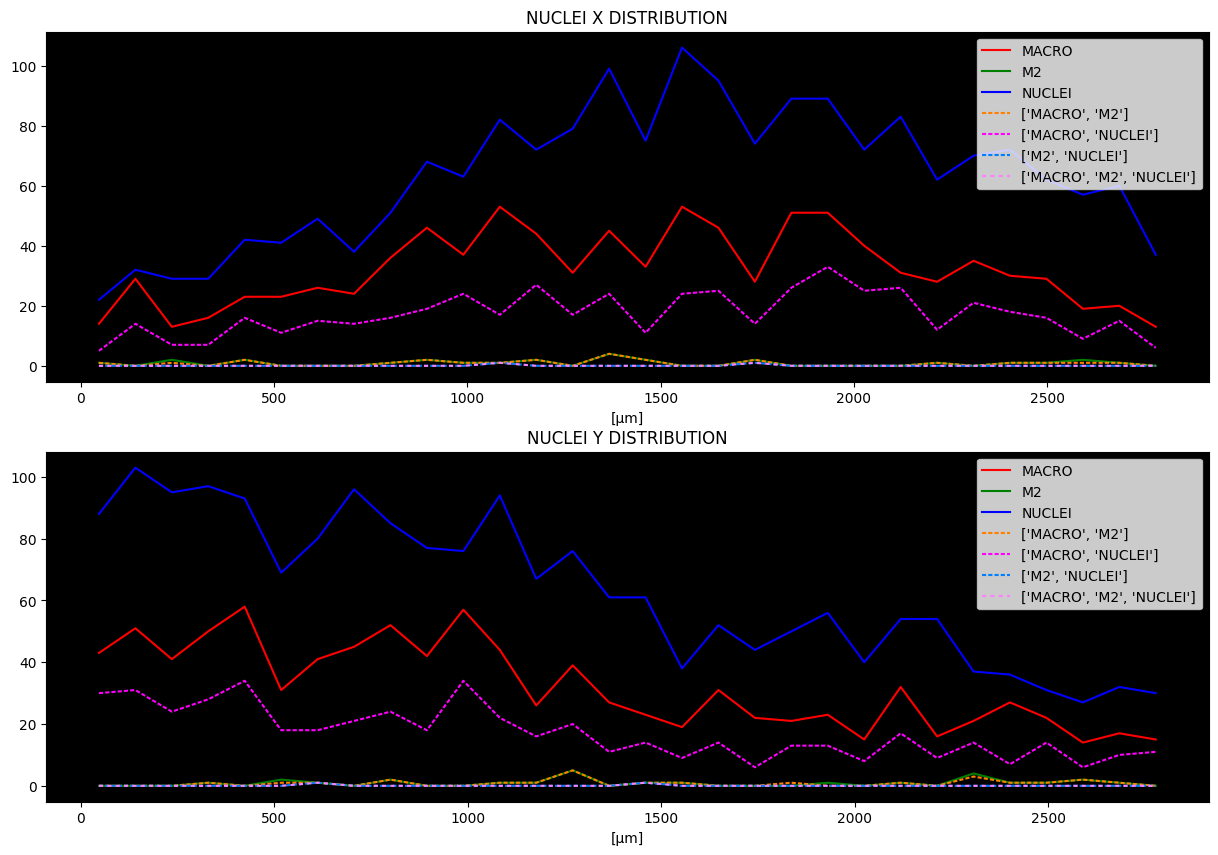

In [22]:
fig, axs = plt.subplots(2,1,figsize=(15,10))

for i, marker in enumerate(labels_df.index):
    xcoor= [t[0] for t in list(labels_df['Mean positions [um]'][i])]
    ycoor= [t[1] for t in list(labels_df['Mean positions [um]'][i])]
    xcount,xbins=np.histogram(xcoor,range=(0,np.shape(im_original)[0]*r_X),bins=30,density=False)
    ycount,ybins=np.histogram(ycoor,range=(0,np.shape(im_original)[1]*r_Y),bins=30,density=False)
    xbin_centers = (xbins[:-1] + xbins[1:]) / 2
    ybin_centers = (ybins[:-1] + ybins[1:]) / 2
    if np.size(marker)==1:
        axs[0].plot(xbin_centers,xcount,label=str(labels_df['Condition'][i]),color=stain_df.loc[str(labels_df['Condition'][i])]['Color'])
        axs[1].plot(ybin_centers,ycount,label=str(labels_df['Condition'][i]),color=stain_df.loc[str(labels_df['Condition'][i])]['Color'])
    else:
        rgb_list=[]
        for k in range(np.size(marker)):
            rgb_list.append(stain_df.loc[str(labels_df['Condition'][i][k])]['Color'])

        colors_rgb = [to_rgb(name) for name in rgb_list]

        r_total, g_total, b_total = 0.0, 0.0, 0.0

        for r, g, b in colors_rgb:
            r_total += r
            g_total += g
            b_total += b
        
        r_final = min(r_total, 1.0)
        g_final = min(g_total, 1.0)
        b_final = min(b_total, 1.0)
    
        final_rgb = (r_final, g_final, b_final)
        
        axs[0].plot(xbin_centers,xcount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        axs[1].plot(ybin_centers,ycount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)

axs[0].set_title('NUCLEI X DISTRIBUTION')
axs[0].set_xlabel('[μm]')
axs[0].legend(loc='upper right')
axs[0].set_facecolor('black')
axs[1].set_title('NUCLEI Y DISTRIBUTION')
axs[1].set_xlabel('[μm]')
axs[1].legend(loc='upper right')
axs[1].set_facecolor('black')

## Evaluate cell size distribution

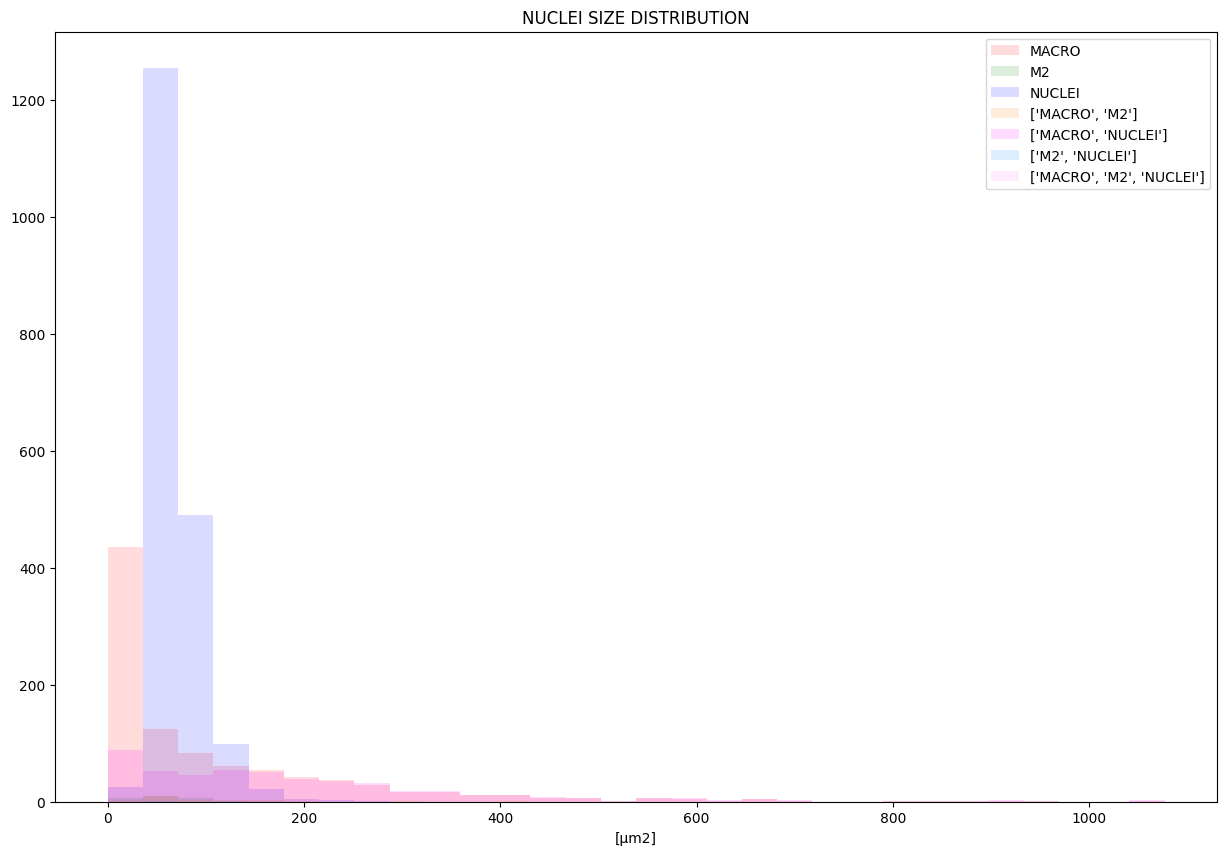

In [23]:
fig, axs = plt.subplots(1,1,figsize=(15,10))

max_size=max([x for t in list(labels_df['Cell size [um2]']) for x in t])

for i, marker in enumerate(labels_df.index):
    sizes= [t for t in list(labels_df['Cell size [um2]'][i])]
    if np.size(marker)==1:
        axs.hist(sizes,range=(0,max_size),bins=30,label=str(labels_df['Condition'][i]), alpha=1/len(labels_df),color=stain_df.loc[str(labels_df['Condition'][i])]['Color'])
    else:
        rgb_list=[]
        for k in range(np.size(marker)):
            rgb_list.append(stain_df.loc[str(labels_df['Condition'][i][k])]['Color'])

        colors_rgb = [to_rgb(name) for name in rgb_list]

        r_total, g_total, b_total = 0.0, 0.0, 0.0

        for r, g, b in colors_rgb:
            r_total += r
            g_total += g
            b_total += b
        
        r_final = min(r_total, 1.0)
        g_final = min(g_total, 1.0)
        b_final = min(b_total, 1.0)
    
        final_rgb = (r_final, g_final, b_final)
        
        axs.hist(sizes,range=(0,max_size),bins=30,label=str(labels_df['Condition'][i]), alpha=1/len(labels_df),color=final_rgb)

axs.set_title('NUCLEI SIZE DISTRIBUTION')
axs.set_xlabel('[μm2]')
axs.legend(loc='upper right')

### Create a complete report XSL

In [24]:
with pd.ExcelWriter(Path(tiff_file).stem+'_report.xlsx', engine='xlsxwriter') as writer:
    stain_complete_df.to_excel(writer, sheet_name='Staining', index=True)

    for i, marker in enumerate(labels_df.index):
        xlsx_dict={}
        if np.size(marker)==1:
            for k in range(int(labels_df['Number'][i])):
                xlsx_dict[k]=[labels_df['Mean positions [um]'][i][k][0],labels_df['Mean positions [um]'][i][k][1],labels_df['Cell size [um2]'][i][k]]
                cell_df = pd.DataFrame.from_dict(xlsx_dict, orient='index', columns=['X position [um]','Y position [um]','Cell size [um2]'])
                cell_df.index+=1
        else:
            for k in range(int(labels_df['Number'][i])):
                xlsx_dict[k]=[item for sublist in [list(labels_df['Shared labels'][i][k]),list(labels_df['Mean positions [um]'][i][k]),labels_df['Cell size [um2]'][i][k]] for item in (sublist if isinstance(sublist, list) else [sublist])]       
                cell_df = pd.DataFrame.from_dict(xlsx_dict, orient='index', columns=[item for sublist in [list(labels_df.index[i]),'X position [um]','Y position [um]','Cell size [um2]'] for item in (sublist if isinstance(sublist, list) else [sublist])])
                cell_df.index+=1
                
        cell_df.to_excel(writer, sheet_name=str(marker), index=True)

    resume_df=labels_df.drop(columns=['Shared labels','Mean positions [um]','Cell size [um2]'])
    resume_df['%']=100.0*labels_df['Number']/tot_cells
    resume_df['Mean size [um2]']=[np.mean(t) for t in list(labels_df['Cell size [um2]'])]
    resume_df.loc['TOTAL']=['', '', tot_cells, '100', np.mean([np.mean(t) for t in list(labels_df['Cell size [um2]'][:len(stain_df)])])]

    resume_df.to_excel(writer, sheet_name='RECAP', index=True)